<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/FeatureSelection/EmbeddedMethods/3_4_Logistic_regression_coefficients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic Regression Coefficients

Linear regression is a straightforward approach for predicting a quantitative response Y on the basis of a different predictor variable X1, X2, ... Xn. It assumes that there is a linear relationship between X(s) and Y. Mathematically, we can write this linear relationship as Y ≈ β0 + β1X1 + β2X2 + ... + βnXn.

**The magnitude of the coefficients is directly influenced by the scale of the features**. Therefore, to compare coefficients across features, it is importance to have all features within the same scale. This is why, normalisation is important for variable importance and feature selection in linear models. Normalisation is important as well for model performance.

In addition, Linear Regression makes the following assumptions over the predictor variables X:
- Linear relationship with the outcome Y
- Multivariate normality (X should follow a Gaussian distribution)
- No or little multicollinearity (Xs should not be linearly related to one another)
- Homoscedasticity (variance should be the same)

Homoscedasticity, also known as homogeneity of variance, describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables (Xs) and the dependent variable (Y)) is the same across all values of the independent variables.

Therefore, there are a lot of assumptions that need to be met in order to make a fair comparison of the features by using only their regression coefficients.

In addition, these coefficients may be penalised by regularisation, therefore being smaller than if we were to compare only that individual feature with the target.

Having said this, you can still select features based on linear regression coefficients, provided you keep all of these in mind at the time of analysing the outcome.

Personally, this is not my feature selection method of choice, although I find it useful to interpret the output of the model.


I will demonstrate how to select features based on the regression coefficients using sklearn on a classification problem, using the Paribas claims dataset from Kaggle.

In [1]:
!pip install --user kaggle
!mkdir .kaggle
import json
token = {"username":"vinay10949","key":"59c4901452f76ce62979e5b0997e240b"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)


In [3]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c bnp-paribas-cardif-claims-management
!unzip train.csv.zip

 91% 45.0M/49.4M [00:00<00:00, 34.6MB/s]
100% 49.4M/49.4M [00:00<00:00, 72.3MB/s]
  0% 0.00/162k [00:00<?, ?B/s]
100% 162k/162k [00:00<00:00, 54.5MB/s]
 67% 33.0M/49.4M [00:00<00:00, 29.1MB/s]
100% 49.4M/49.4M [00:00<00:00, 56.4MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [5]:
# load dataset
data = pd.read_csv('train.csv', nrows=50000)
data.shape

(50000, 133)

In [0]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [7]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [9]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target', 'ID'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [10]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
# here I will do the model fitting and feature selection
# altogether in one line of code

# first I specify the Logistic Regression model, here I
# select the Ridge Penalty (l2)(it is the default parameter in sklearn)

# remember that here I want to evaluate the coefficient magnitud
# itself and not whether lasso shrinks coefficients to zero

# ideally, I want to avoid regularisation at all, so the coefficients
# are not affected (modified) by the penalty of the regularisation

# In order to do this in sklearn, I set the parameter C really by
# this is basically like fitting a non regularised logistic regression

# Then I use the selectFromModel object from sklearn
# to automatically select the features

# set C to 1000, to avoid regularisation
sel_ = SelectFromModel(LogisticRegression(C=1000, penalty='l2')) 
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SelectFromModel(estimator=LogisticRegression(C=1000, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l2',
                                             random_state=None, solver='lbfgs',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [12]:
# this command let's me visualise those features that were kept.

# sklearn will select those features which coefficients are greater
# than the mean of all the coefficients.

# it compares absolute values of coefficients. More on this in a second.

sel_.get_support()

array([False, False, False,  True,  True,  True,  True, False,  True,
       False,  True, False, False,  True,  True, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False,  True,  True,  True, False,  True, False, False, False,
       False, False, False,  True,  True, False, False,  True, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False])

In [13]:
# let's add the variable names and order it for clearer visualisation
# and then let's sum the number of selected features

selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

39

In [14]:
# the number of features which coefficient was shrank to zero
# is zero, as expected, because we are not making a regularised 
# regression (I set C too big, which is inversely proportional
# to the penaly).

np.sum(sel_.estimator_.coef_ == 0)

0

In [18]:
# as select from model selects coefficients above the mean
# of all coefficients, let's calculate first the mean

sel_.estimator_.coef_.mean()

0.008617049763687578

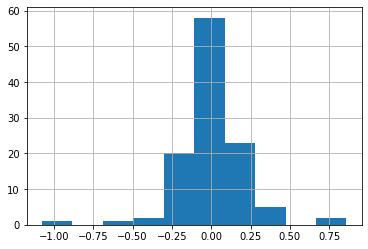

In [19]:
# and now let's plot the distribution of coefficients

pd.Series(sel_.estimator_.coef_.ravel()).hist()

As expected, some coefficients are positive and some are negative, suggesting that some features are negatively associated with the outcome (the more of the feature the less of the outcome) and viceversa.

However, the absolute value of the coefficients inform about the importance of the feature on the outcome, and not the sign. Therefore, the feature selection is done filtering on absolute values of coefficients. See below.

In [20]:
# the feature importance is informed by the absolute value of
# the coefficient, and not the sign.
# therefore, let's recalculate the mean using the absolute values instead

np.abs(sel_.estimator_.coef_).mean()

0.12950452979282426

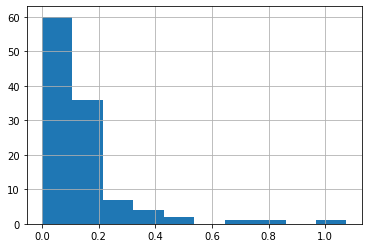

In [21]:
# and now let's plot the histogram of absolute coefficients

pd.Series(np.abs(sel_.estimator_.coef_).ravel()).hist()

In [22]:
# and now, let's compare the  amount of selected features
# with the amount of features which coefficient is above the
# mean coefficient, to make sure we understand the output of
# sklearn

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients greater than the mean coefficient: {}'.format(
    np.sum(np.abs(sel_.estimator_.coef_) > np.abs(sel_.estimator_.coef_).mean())))

total features: 112
selected features: 39
features with coefficients greater than the mean coefficient: 39


Therefore, we see how select from model works. It will select all the coefficients which absolute values are greater than the mean.
You can of course select a different threshold. Visit the documentation in sklearn to learn how to change this parameter.

This is all for this lecture. See you in the next one.